In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix , accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import torch
import torch.nn as nn
from torch.utils.data import DataLoader,Dataset

In [2]:
df=pd.read_csv(r'https://raw.githubusercontent.com/DataScienceHamburg/AppliedNLPMaterial/master/010_IntroToNLP/data/Tweets.csv').dropna()
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [3]:
BATCH_SIZE = 128
NUM_EPOCHS = 80
MAX_FEATURES = 10

In [4]:
cat_id = {'neutral': 1,
          'negative': 0,
          'positive': 2}

df['class'] = df['sentiment'].map(cat_id)

In [5]:
# X=df['text'].values
# y=df['class'].values
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=123)

In [8]:
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [ ]:
 !pip install sentence_transformers

In [9]:
emb_model = SentenceTransformer('sentence-transformers/all-mpnet-base-v1')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/9.90k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/591 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [10]:
sentences = [ "Each sentence is converted"]
embeddings = emb_model.encode(sentences)
print(embeddings.squeeze().shape)

(768,)


In [11]:
import pickle

In [13]:
X = emb_model.encode(df['text'].values)

with open("tweets_X.pkl", "wb") as output_file:
    pickle.dump(X, output_file)

In [14]:
with open("tweets_X.pkl", "rb") as input_file:
    X = pickle.load(input_file)

y = df['class'].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.5, random_state=123)

In [ ]:
# one_hot = CountVectorizer()
# X_train_onehot=one_hot.fit_transform(X_train)
# X_test_onehot=one_hot.transform(X_test)

In [22]:
class SentimentData(Dataset):
  def __init__(self,x,y):
    super().__init__()
    self.x=torch.Tensor(x)
    self.y=torch.Tensor(y).type(torch.LongTensor)
    self.len=len(self.x)

  def __len__ (self):
    return self.len

  def __getitem__ (self,index):
    return self.x[index],self.y[index]

In [23]:
# train_ds = SentimentData(x= X_train_onehot, y = y_train)
# test_ds = SentimentData(X_test_onehot, y_test)


train_ds = SentimentData(x= X_train, y = y_train)
test_ds = SentimentData(X_test, y_test)

# %% Dataloader
train_loader = DataLoader(dataset=train_ds, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=15000)

In [24]:
class SentimentModel(nn.Module):
  def __init__(self,NUM_FEATURES, NUM_CLASSES,HIDDEN=10):
    super().__init__()
    self.linear = nn.Linear(NUM_FEATURES, HIDDEN)
    self.linear2 = nn.Linear(HIDDEN, NUM_CLASSES)
    self.relu = nn.ReLU()
    self.log_softmax = nn.LogSoftmax(dim=1)

  def forward(self, x):
      x = self.linear(x)
      x = self.relu(x)
      x = self.linear2(x)
      x = self.log_softmax(x)
      return x



In [25]:
# model = SentimentModel(NUM_FEATURES = X_train_onehot.shape[1], NUM_CLASSES = 3)
model = SentimentModel(NUM_FEATURES = X_train.shape[1], NUM_CLASSES = 3)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters())

In [26]:
train_losses=[]

for e in range(NUM_EPOCHS):
  curr_loss=0
  for x_batch,y_batch in train_loader:
    optimizer.zero_grad()
    y_pred_log=model(x_batch)
    loss=criterion(y_pred_log,y_batch)
    curr_loss += loss.item()
    loss.backward()
    optimizer.step()
  train_losses.append(curr_loss)
  print(f"Epoch {e}, Loss: {curr_loss}")


Epoch 0, Loss: 109.18533909320831
Epoch 1, Loss: 90.2855840921402
Epoch 2, Loss: 81.73354911804199
Epoch 3, Loss: 78.09514886140823
Epoch 4, Loss: 76.30546432733536
Epoch 5, Loss: 75.39404392242432
Epoch 6, Loss: 74.51302701234818
Epoch 7, Loss: 73.88737910985947
Epoch 8, Loss: 73.34695726633072
Epoch 9, Loss: 72.82970660924911
Epoch 10, Loss: 72.43862867355347
Epoch 11, Loss: 72.08498829603195
Epoch 12, Loss: 71.79569309949875
Epoch 13, Loss: 71.41290694475174
Epoch 14, Loss: 71.13541597127914
Epoch 15, Loss: 70.91606849431992
Epoch 16, Loss: 70.55877536535263
Epoch 17, Loss: 70.22263091802597
Epoch 18, Loss: 69.91653889417648
Epoch 19, Loss: 69.64197838306427
Epoch 20, Loss: 69.45113053917885
Epoch 21, Loss: 69.14452448487282
Epoch 22, Loss: 68.96152883768082
Epoch 23, Loss: 68.53733420372009
Epoch 24, Loss: 68.40040385723114
Epoch 25, Loss: 68.0892758667469
Epoch 26, Loss: 67.94446617364883
Epoch 27, Loss: 67.63859644532204
Epoch 28, Loss: 67.49784424901009
Epoch 29, Loss: 67.240304

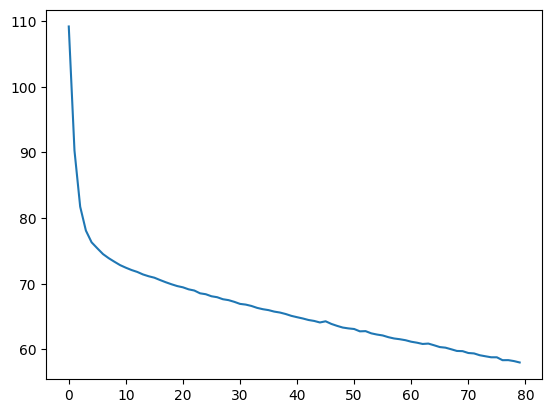

In [27]:
sns.lineplot(x=list(range(len(train_losses))), y= train_losses)
plt.show()

In [28]:
with torch.no_grad():
  for x_batch,y_batch in test_loader :
    ytest_pred_log=model(x_batch)
    ytest_pred=torch.argmax(ytest_pred_log,dim=1)

y_test_pred_np = ytest_pred.squeeze().cpu().numpy()


In [29]:
acc = accuracy_score(y_pred=ytest_pred, y_true = y_test)
acc

0.6847161572052402

<Axes: >

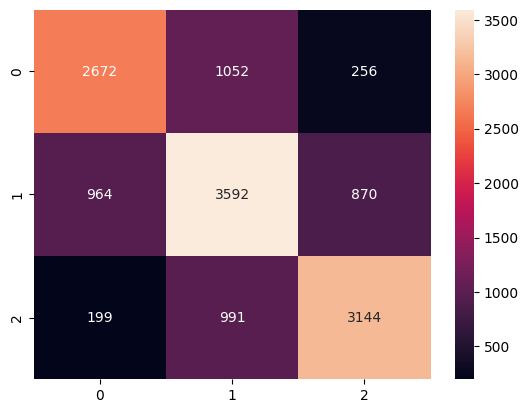

In [30]:
sns.heatmap(confusion_matrix(y_test_pred_np, y_test), annot=True, fmt=".0f")